In [39]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

# --- Current Quiz Data URL ---
current_quiz_url = "https://www.jsonkeeper.com/b/LLQT"
current_response = requests.get(current_quiz_url)
current_data = current_response.json()

# --- Historical Quiz Data URL ---
historical_quiz_url = "https://api.jsonserve.com/XgAgFJ"
historical_response = requests.get(historical_quiz_url)
historical_data = historical_response.json()


In [40]:
print("=== Current Quiz Data Schema ===")
print(json.dumps(current_data, indent=4))

print("\n=== Historical Quiz Data Schema ===")
print(json.dumps(historical_data, indent=4))

=== Current Quiz Data Schema ===
{
    "quiz": {
        "id": 43,
        "name": null,
        "title": "Structural Organisation in Animals and Plants (7)",
        "description": "",
        "difficulty_level": null,
        "topic": "Structural Organisation in Animals",
        "time": "2024-07-03T00:00:00.000+05:30",
        "is_published": true,
        "created_at": "2024-07-03T11:00:08.958+05:30",
        "updated_at": "2024-09-23T18:43:27.751+05:30",
        "duration": 128,
        "end_time": "2024-07-04T00:00:00.000+05:30",
        "negative_marks": "1.0",
        "correct_answer_marks": "4.0",
        "shuffle": true,
        "show_answers": true,
        "lock_solutions": false,
        "is_form": false,
        "show_mastery_option": false,
        "quiz_type": null,
        "is_custom": false,
        "banner_id": null,
        "exam_id": null,
        "show_unanswered": false,
        "ends_at": "2025-01-18",
        "lives": null,
        "live_count": "Free Test",
  

In [41]:
# The current quiz data is nested under the key "quiz"
current_quiz = current_data.get('quiz', {})
if not current_quiz:
    raise ValueError("No quiz data found in current quiz API response.")

# Extract key details from the current quiz
quiz_id    = current_quiz.get('id')
quiz_title = current_quiz.get('title')
# Use the provided "topic" if available; otherwise, derive it from the title.
quiz_topic = current_quiz.get('topic', quiz_title.split('(')[0].strip())

# Normalize the list of questions
current_questions = pd.json_normalize(current_quiz.get('questions', []))

# In the provided snippet, there is no "correct_answer" in each question.
# For demonstration purposes, if not available, assume "A" is the correct answer.
if 'correct_answer' not in current_questions.columns:
    current_questions['correct_answer'] = "A"

# Create a mapping from question ID (as string) to the correct answer.
correct_answers = dict(zip(current_questions['id'].astype(str), current_questions['correct_answer']))


In [42]:
# Load the submission data from the local JSON file.
with open('quiz_submission.json', 'r') as f:
    submission_data = json.load(f)

# Normalize the submission data for further analysis if needed.
submission_df = pd.json_normalize(submission_data)

# Extract the response map: a dictionary mapping question IDs to the student's selected answer.
response_map = submission_data.get('response_map', {})


In [43]:
print("\n=== Submission Data Schema ===")
print(json.dumps(submission_data, indent=4))


=== Submission Data Schema ===
{
    "id": 336566,
    "quiz_id": 43,
    "user_id": "7ZXdz3zHuNcdg9agb5YpaOGLQqw2",
    "submitted_at": "2025-01-17T15:51:29.859+05:30",
    "created_at": "2025-01-17T15:51:29.871+05:30",
    "updated_at": "2025-01-17T15:51:29.871+05:30",
    "score": 32,
    "trophy_level": 2,
    "accuracy": "80 %",
    "speed": "100",
    "final_score": "30.0",
    "negative_score": "2.0",
    "correct_answers": 8,
    "incorrect_answers": 2,
    "source": "live",
    "type": "topic",
    "started_at": "2025-01-17T16:20:44.000+05:30",
    "ended_at": "2025-01-17T16:21:28.000+05:30",
    "duration": "15:00",
    "better_than": 24,
    "total_questions": 128,
    "rank_text": "Topic Rank - #2402",
    "mistakes_corrected": 6,
    "initial_mistake_count": 8,
    "response_map": {
        "1837": 7363,
        "1848": 7407,
        "1852": 7423,
        "1862": 7464,
        "1877": 7525,
        "1878": 7529,
        "1900": 7617,
        "1917": 7685,
        "1934": 

In [44]:
# Normalize the historical quiz data into a DataFrame.
historical_df = pd.json_normalize(historical_data, sep='_')

# Derive a topic column by extracting text before '(' in the quiz title.
historical_df['topic'] = historical_df['quiz_title'].str.split('(').str[0].str.strip()

# Convert the accuracy field from a percentage string to a float (if available).
if 'accuracy' in historical_df.columns:
    historical_df['accuracy_pct'] = historical_df['accuracy'].str.replace('%', '').astype(float)
else:
    # Default value for demonstration if the field is missing.
    historical_df['accuracy_pct'] = 75.0


In [45]:
# Compare the student's responses with the correct answers.
incorrect_questions = []
for q_id, selected in response_map.items():
    # Compare as strings to avoid type mismatches.
    if q_id in correct_answers and str(selected) != str(correct_answers[q_id]):
        incorrect_questions.append(q_id)

total_questions = len(correct_answers)
num_incorrect   = len(incorrect_questions)
current_accuracy = (total_questions - num_incorrect) / total_questions * 100 if total_questions > 0 else 0

# Derive the current quiz topic (using provided topic or extracting from title).
current_topic = quiz_topic if quiz_topic else quiz_title.split('(')[0].strip()


In [46]:
# Compute topic-wise statistics based on historical performance.
topic_stats = historical_df.groupby('topic').agg(
    attempts       = ('quiz_id', 'count'),
    avg_accuracy   = ('accuracy_pct', 'mean'),
    total_correct  = ('correct_answers', 'sum'),
    total_incorrect= ('incorrect_answers', 'sum')
).reset_index()

# Identify weak topics: those with an average accuracy below 70%.
weak_topics = topic_stats[topic_stats['avg_accuracy'] < 70].sort_values('avg_accuracy')


In [47]:
# ---- Current Quiz Performance Analysis ----

# Check if a "correct_answer" field exists; if not, simulate one (assume "A" is correct for all questions)
if 'correct_answer' not in current_questions.columns:
    current_questions['correct_answer'] = "A"

# Create a mapping: question id (as string) -> correct answer
correct_answers = dict(zip(current_questions['id'].astype(str), current_questions['correct_answer']))

# Compare the student's responses from submission_data with the correct answers.
response_map = submission_data.get('response_map', {})
incorrect_questions = []
for q_id, student_answer in response_map.items():
    if q_id in correct_answers and str(student_answer) != str(correct_answers[q_id]):
        incorrect_questions.append(q_id)

total_questions = len(correct_answers)
current_accuracy = (total_questions - len(incorrect_questions)) / total_questions * 100 if total_questions > 0 else 0
print(f"Current Quiz Performance: {current_accuracy:.2f}% accuracy ({len(incorrect_questions)} incorrect out of {total_questions}).")

# ---- Historical Data Analysis ----

# Convert "accuracy" from a percentage string to a float (if available)
if 'accuracy' in historical_df.columns:
    historical_df['accuracy_pct'] = historical_df['accuracy'].str.replace('%', '').astype(float)
else:
    historical_df['accuracy_pct'] = 75.0  # Default value if missing

# Extract topic from the quiz title (assuming title format: "Topic (details)")
historical_df['topic'] = historical_df['quiz_title'].str.split('(').str[0].str.strip()

# If "difficulty_level" is missing, simulate a default difficulty level (for demonstration)
if 'difficulty_level' not in historical_df.columns:
    historical_df['difficulty_level'] = "Medium"

# Group historical data by topic to see average accuracy and attempt counts.
performance_by_topic = historical_df.groupby('topic').agg(
    avg_accuracy=('accuracy_pct', 'mean'),
    attempts=('quiz_id', 'count')
).reset_index()

# Group historical data by difficulty level.
performance_by_difficulty = historical_df.groupby('difficulty_level').agg(
    avg_accuracy=('accuracy_pct', 'mean'),
    attempts=('quiz_id', 'count')
).reset_index()

print("\nPerformance by Topic:")
print(performance_by_topic)

print("\nPerformance by Difficulty Level:")
print(performance_by_difficulty)

# Compute overall historical accuracy
historical_overall_accuracy = historical_df['accuracy_pct'].mean()
print(f"\nOverall Historical Accuracy: {historical_overall_accuracy:.2f}%")


Current Quiz Performance: 92.19% accuracy (10 incorrect out of 128).

Performance by Topic:
                                         topic  avg_accuracy  attempts
0                 HUMAN HEALTH AND DISEASE PYQ         93.00         1
1                             Human Physiology         70.75         4
2                         Human Physiology PYQ         80.00         3
3               MICROBES IN HUMAN WELFARE  PYQ        100.00         1
4  PRINCIPLES OF INHERITANCE AND VARIATION PYQ         30.00         1
5                      REPRODUCTIVE HEALTH PYQ         92.00         2
6                                 Reproduction         40.50         2

Performance by Difficulty Level:
  difficulty_level  avg_accuracy  attempts
0           Medium     72.214286        14

Overall Historical Accuracy: 72.21%


In [48]:
# ---- Define a Threshold for Weak Performance ----
weak_threshold = 70.0  # For example, topics with avg accuracy below 70% are considered weak.

# Identify weak topics from historical data.
weak_topics = performance_by_topic[performance_by_topic['avg_accuracy'] < weak_threshold]
insight_weak_topics = weak_topics[['topic', 'avg_accuracy', 'attempts']].to_dict('records')

# Determine the current quiz's topic (preferably provided or derived from the title)
current_topic = current_quiz.get('topic', current_quiz.get('title', 'Unknown')).split('(')[0].strip()

# Compare current performance with historical performance for this topic.
historical_topic_perf = performance_by_topic[performance_by_topic['topic'] == current_topic]
if not historical_topic_perf.empty:
    historical_topic_accuracy = historical_topic_perf['avg_accuracy'].iloc[0]
else:
    historical_topic_accuracy = None

# Generate an insight regarding improvement trends or performance gaps.
if historical_topic_accuracy is not None:
    if current_accuracy > historical_topic_accuracy:
        trend_insight = (
            f"Improvement Trend: Your current performance in '{current_topic}' "
            f"({current_accuracy:.2f}%) is higher than the historical average ({historical_topic_accuracy:.2f}%)."
        )
    else:
        trend_insight = (
            f"Performance Gap: Your current performance in '{current_topic}' "
            f"({current_accuracy:.2f}%) is below the historical average ({historical_topic_accuracy:.2f}%). "
            "Consider revisiting key concepts."
        )
else:
    trend_insight = f"No historical performance data available for topic '{current_topic}'."

# Compile insights into a summary.
insights = {
    'weak_topics': insight_weak_topics,
    'current_topic_trend': trend_insight,
    'overall_current_accuracy': current_accuracy,
    'overall_historical_accuracy': historical_overall_accuracy
}

print("\n=== Insights Summary ===")
print(json.dumps(insights, indent=4))



=== Insights Summary ===
{
    "weak_topics": [
        {
            "topic": "PRINCIPLES OF INHERITANCE AND VARIATION PYQ",
            "avg_accuracy": 30.0,
            "attempts": 1
        },
        {
            "topic": "Reproduction",
            "avg_accuracy": 40.5,
            "attempts": 2
        }
    ],
    "current_topic_trend": "No historical performance data available for topic 'Structural Organisation in Animals'.",
    "overall_current_accuracy": 92.1875,
    "overall_historical_accuracy": 72.21428571428571
}


In [49]:
recommendations = []

# Recommendation for weak topics: if any topics have low historical accuracy.
if not weak_topics.empty:
    weak_topic_list = weak_topics['topic'].tolist()
    recommendations.append(
        f"Focus on these weak topics: {', '.join(weak_topic_list)}. "
        "Revisit core concepts, practice more questions, and seek additional resources if needed."
    )
else:
    recommendations.append("No significant weak topics identified. Maintain your current study routine.")

# Recommendation based on the current topic trend:
if "Performance Gap" in trend_insight:
    recommendations.append(
        f"For the topic '{current_topic}', since your current performance is below the historical average, "
        "review your class notes, re-solve previous quiz questions, and consider targeted practice exercises."
    )
else:
    recommendations.append(
        f"Great job on '{current_topic}'! Continue with your current study habits and challenge yourself with more difficult questions."
    )

# Recommendation based on difficulty level patterns:
# (Assuming if any difficulty level shows an average below the weak threshold, recommend extra practice.)
low_difficulty = performance_by_difficulty[performance_by_difficulty['avg_accuracy'] < weak_threshold]
if not low_difficulty.empty:
    difficult_levels = low_difficulty['difficulty_level'].tolist()
    recommendations.append(
        f"Consider focusing on practicing more questions at the following difficulty levels: {', '.join(difficult_levels)}."
    )
else:
    recommendations.append("Your performance across different difficulty levels appears balanced.")

# Output the recommendations.
print("\n=== Recommendations ===")
for rec in recommendations:
    print(f"- {rec}")



=== Recommendations ===
- Focus on these weak topics: PRINCIPLES OF INHERITANCE AND VARIATION PYQ, Reproduction. Revisit core concepts, practice more questions, and seek additional resources if needed.
- Great job on 'Structural Organisation in Animals'! Continue with your current study habits and challenge yourself with more difficult questions.
- Your performance across different difficulty levels appears balanced.


C:\Users\Naman Dubey\AppData\Local\Temp\ipykernel_7696\424934009.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12, wrap=True)


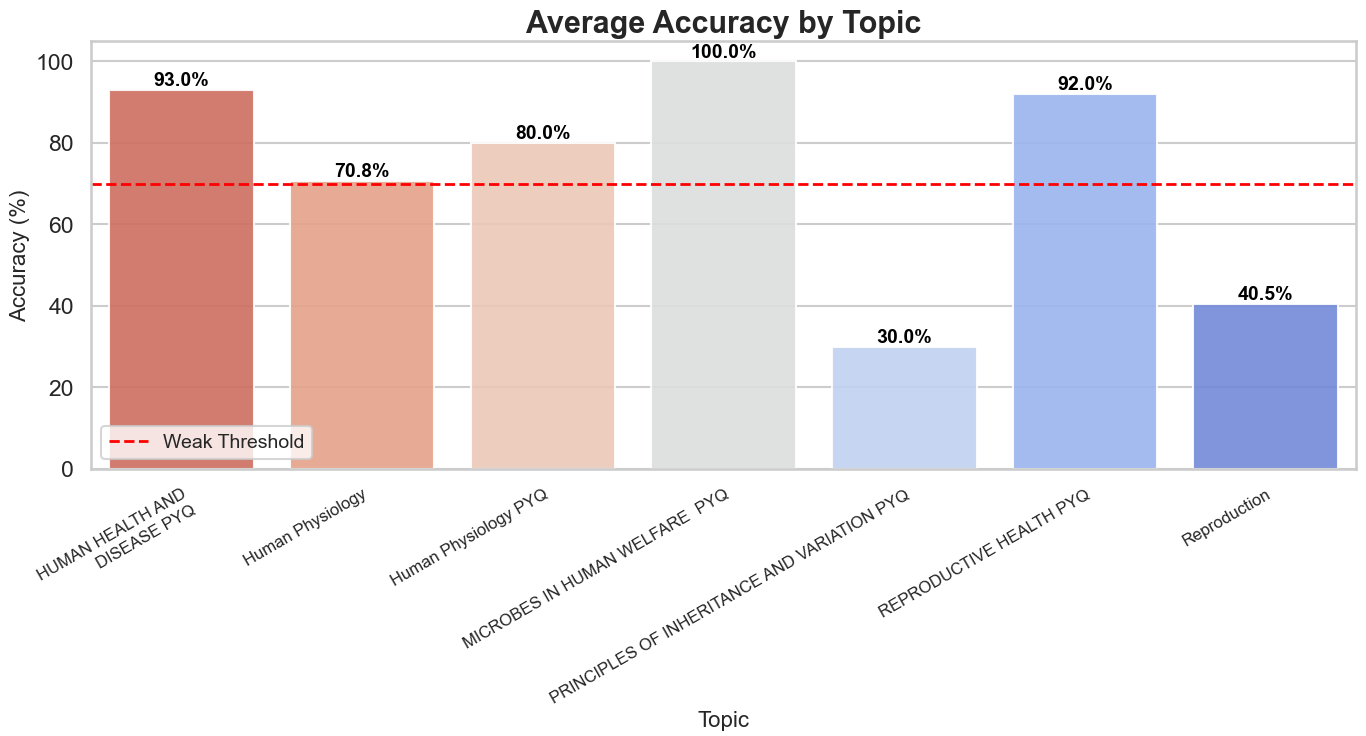

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(14, 7))  # Increase figure size for better readability

# Create the bar plot
ax = sns.barplot(
    data=performance_by_topic,
    x='topic',
    y='avg_accuracy',
    hue='topic',        # Assign hue to x variable to avoid deprecation warning
    palette='coolwarm_r',
    dodge=False,
    alpha=0.9,
    legend=False        # Disable redundant legend
)

# Add the threshold line
ax.axhline(weak_threshold, ls='--', c='red', lw=2, label="Weak Threshold")

# Titles and labels
ax.set_title("Average Accuracy by Topic", fontsize=22, weight='bold')
ax.set_xlabel("Topic", fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=16)

# Improve x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12, wrap=True)

# Annotate bars with accuracy percentages
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold',
        color='black'
    )

# Move legend to bottom-left
plt.legend(loc='lower left', fontsize=14, frameon=True)

# Adjust layout
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotate and align x-axis labels properly
plt.tight_layout()
plt.show()


C:\Users\Naman Dubey\AppData\Local\Temp\ipykernel_7696\1603216325.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_diff = sns.barplot(


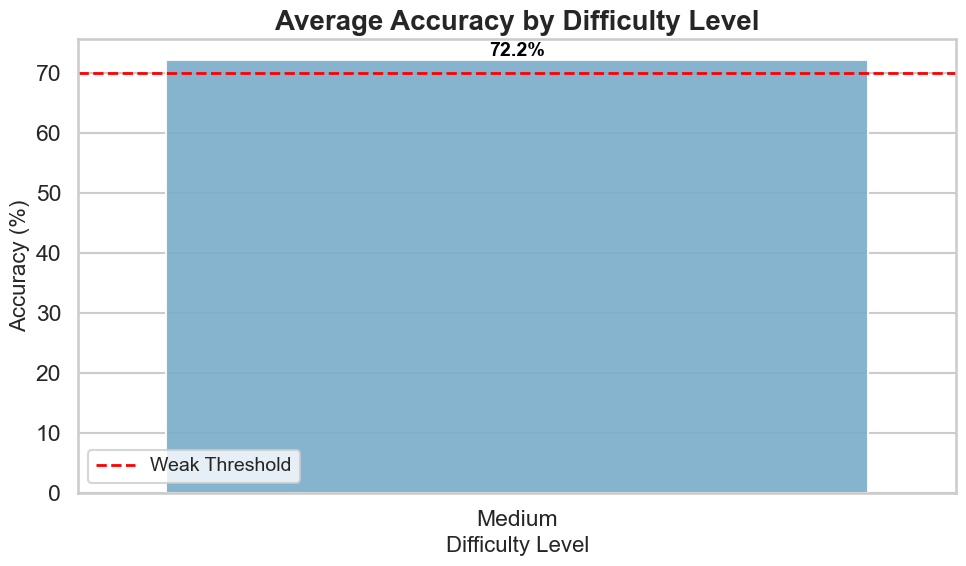

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme for aesthetics
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

# Create the bar plot with the correct x column name
ax_diff = sns.barplot(
    data=performance_by_difficulty,
    x='difficulty_level',  # Use the correct column name
    y='avg_accuracy',
    palette='Blues_r',     # Vibrant color scheme
    alpha=0.9              # Slight transparency for a clean look
)

# Add the threshold line with a label
ax_diff.axhline(weak_threshold, ls='--', c='red', lw=2, label="Weak Threshold")

# Annotate each bar with its accuracy percentage
for p in ax_diff.patches:
    height = p.get_height()
    ax_diff.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold',
        color='black'
    )

# Set titles and axis labels
ax_diff.set_title("Average Accuracy by Difficulty Level", fontsize=20, weight='bold')
ax_diff.set_xlabel("Difficulty Level", fontsize=16)
ax_diff.set_ylabel("Accuracy (%)", fontsize=16)

# Place the legend at the bottom left
plt.legend(loc='lower left', fontsize=14, frameon=True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [76]:
# --- Insights Summary ---
insights = {
    'weak_topics': weak_topics[['topic', 'avg_accuracy', 'attempts']].to_dict('records'),
    'current_quiz': {
        'topic'              : current_topic,
        'accuracy'           : current_accuracy,
        'incorrect_count'    : num_incorrect,
        'total_questions'    : total_questions,
        'incorrect_question_ids': incorrect_questions
    }
}

# --- Recommendations ---
recommendations = [
    f"Focus on improving in: {', '.join(weak_topics['topic'].tolist()) if not weak_topics.empty else 'all topics'}.",
    f"Review the {num_incorrect} incorrect question(s) in your current quiz on {current_topic}.",
    "Practice higher difficulty questions and revise concepts in your weak areas."
]




# BONUS

In [53]:
import pandas as pd
import numpy as np
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

# Set up logging to display INFO messages
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set Seaborn theme (for any visualizations later)
sns.set_theme(style="whitegrid", context="talk")


In [54]:
# Assuming that 'historical_df' has already been loaded and processed from your actual historical quiz data,
# and that 'current_accuracy' has been computed from the student's current quiz submission.

# Compute overall historical accuracy using your actual historical quiz data.
historical_overall_accuracy = historical_df['accuracy_pct'].mean() if not historical_df.empty else 0
logging.info(f"Historical Overall Accuracy: {historical_overall_accuracy:.2f}%")

# Log the current quiz accuracy (computed from actual submission data)
logging.info(f"Current Quiz Accuracy: {current_accuracy:.2f}%")

# Student Persona Analysis based on performance thresholds:
# - "Consistent Achiever" if both historical and current accuracies are high (>=85%).
# - "Struggling Learner" if historical accuracy is low (<60%).
# - "Upward Trajectory Learner" if current accuracy exceeds historical accuracy.
# - "Steady Performer" otherwise.
if historical_overall_accuracy >= 85 and current_accuracy >= 85:
    persona = "Consistent Achiever"
elif historical_overall_accuracy < 60:
    persona = "Struggling Learner"
elif current_accuracy > historical_overall_accuracy:
    persona = "Upward Trajectory Learner"
else:
    persona = "Steady Performer"

student_persona_insight = {
    'historical_accuracy': historical_overall_accuracy,
    'current_accuracy': current_accuracy,
    'persona': persona
}

logging.info("Student Persona Analysis Complete:")
logging.info(json.dumps(student_persona_insight, indent=4))


2025-02-09 18:13:00,689 - INFO - Historical Overall Accuracy: 72.21%
2025-02-09 18:13:00,690 - INFO - Current Quiz Accuracy: 92.19%
2025-02-09 18:13:00,690 - INFO - Student Persona Analysis Complete:
2025-02-09 18:13:00,691 - INFO - {
    "historical_accuracy": 72.21428571428571,
    "current_accuracy": 92.1875,
    "persona": "Upward Trajectory Learner"
}


In [55]:
print(historical_df.head())

       id  quiz_id                       user_id  \
0  336497       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
1  336448        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
2  333330       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
3  333242        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
4  329504       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   

                    submitted_at                     created_at  \
0  2025-01-17T15:30:18.027+05:30  2025-01-17T15:30:18.044+05:30   
1  2025-01-17T15:17:44.042+05:30  2025-01-17T15:17:44.056+05:30   
2  2025-01-16T20:13:19.682+05:30  2025-01-16T20:13:19.699+05:30   
3  2025-01-16T20:00:11.562+05:30  2025-01-16T20:00:11.573+05:30   
4  2025-01-15T20:34:39.462+05:30  2025-01-15T20:34:39.478+05:30   

                      updated_at  score  trophy_level accuracy speed  ...  \
0  2025-01-17T15:30:18.044+05:30    108             2     90 %   100  ...   
1  2025-01-17T15:17:44.056+05:30     92             1    100 %   100  ...   
2  2025-01-16T20:13:19.699+05:30    116             2

In [67]:
import pandas as pd
import logging

# Configure logging if not already set up
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load your actual NEET data.
# Replace 'actual_neet_data.csv' with the path to your data file.
df_model = pd.read_csv('actual_neet_data.csv')

# Ensure that your data contains the required columns:
#   'historical_accuracy', 'current_accuracy', 'total_quizzes', 'weak_topics_count', 'neet_rank'
# If the column names differ, adjust the code accordingly.

# Compute the additional feature: combined_accuracy (simple average of historical and current accuracies)
df_model['combined_accuracy'] = (df_model['historical_accuracy'] + df_model['current_accuracy']) / 2

# Define features and target for model training.
features = ['historical_accuracy', 'current_accuracy', 'total_quizzes', 'weak_topics_count', 'combined_accuracy']
target = 'neet_rank'

X = df_model[features]
y = df_model[target]

logging.info("Data preparation complete. Sample of the prepared dataset:")
logging.info(df_model.head().to_json(orient='records', lines=True))


2025-02-09 18:50:00,796 - INFO - Data preparation complete. Sample of the prepared dataset:
2025-02-09 18:50:00,798 - INFO - {"historical_accuracy":66.8543053481,"current_accuracy":78.8914240769,"total_quizzes":123,"weak_topics_count":0,"neet_rank":262,"combined_accuracy":72.8728647125}
{"historical_accuracy":92.7821437884,"current_accuracy":53.7862984248,"total_quizzes":131,"weak_topics_count":2,"neet_rank":237,"combined_accuracy":73.2842211066}
{"historical_accuracy":82.9397273815,"current_accuracy":57.2732921343,"total_quizzes":131,"weak_topics_count":2,"neet_rank":255,"combined_accuracy":70.1065097579}
{"historical_accuracy":76.9396317889,"current_accuracy":90.4349384837,"total_quizzes":134,"weak_topics_count":0,"neet_rank":170,"combined_accuracy":83.6872851363}
{"historical_accuracy":57.0208388199,"current_accuracy":77.2893076847,"total_quizzes":130,"weak_topics_count":0,"neet_rank":271,"combined_accuracy":67.1550732523}



In [68]:
import numpy as np
import pandas as pd
import logging

# Assume df_model already contains the following columns based on your actual data:
# 'historical_accuracy', 'current_accuracy', 'total_quizzes', 'weak_topics_count', 'combined_accuracy'

# Feature Engineering: Create additional features
df_model['improvement'] = df_model['current_accuracy'] - df_model['historical_accuracy']
df_model['accuracy_ratio'] = df_model['current_accuracy'] / df_model['historical_accuracy']
df_model['interaction_quizzes_weak'] = df_model['total_quizzes'] * df_model['weak_topics_count']
df_model['combined_accuracy_squared'] = df_model['combined_accuracy'] ** 2

# Log a sample of the engineered features
logging.info("Sample of the engineered features:")
logging.info(df_model[['historical_accuracy', 'current_accuracy', 'combined_accuracy', 
                        'improvement', 'accuracy_ratio', 'interaction_quizzes_weak', 'combined_accuracy_squared']].head())

# Define an extended set of features for model training.
features_extended = [
    'historical_accuracy', 
    'current_accuracy', 
    'total_quizzes', 
    'weak_topics_count', 
    'combined_accuracy',
    'improvement',
    'accuracy_ratio',
    'interaction_quizzes_weak',
    'combined_accuracy_squared'
]
target = 'neet_rank'

# Prepare the feature matrix X and target vector y.
X_extended = df_model[features_extended]
y = df_model[target]

2025-02-09 18:50:03,638 - INFO - Sample of the engineered features:
2025-02-09 18:50:03,640 - INFO -    historical_accuracy  current_accuracy  combined_accuracy  improvement  \
0            66.854305         78.891424          72.872865    12.037119   
1            92.782144         53.786298          73.284221   -38.995845   
2            82.939727         57.273292          70.106510   -25.666435   
3            76.939632         90.434938          83.687285    13.495307   
4            57.020839         77.289308          67.155073    20.268469   

   accuracy_ratio  interaction_quizzes_weak  combined_accuracy_squared  
0        1.180050                         0                5310.454411  
1        0.579705                       262                5370.577063  
2        0.690541                       262                4914.922710  
3        1.175401                         0                7003.561693  
4        1.355457                         0                4509.803864  


In [69]:
import numpy as np
import pandas as pd
import logging
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


# --- Split the Extended Data into Training and Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.2, random_state=42)

# --- Define the Parameter Grid for XGBRegressor ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# --- Initialize the XGBRegressor ---
xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')

# --- Set Up GridSearchCV for Hyperparameter Tuning ---
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# --- Perform Grid Search on the Training Data ---
grid_search.fit(X_train, y_train)

# Log and print the best parameters found.
logging.info("Best Parameters Found: %s", grid_search.best_params_)
print("Best Parameters Found:", grid_search.best_params_)

# --- Use the Best Estimator from Grid Search as the Final Model ---
model = grid_search.best_estimator_
logging.info("XGBRegressor model training complete with hyperparameter tuning.")

# --- Perform 5-Fold Cross-Validation on the Training Data with the Tuned Model ---
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
logging.info(f"Cross-validated RMSE: {cv_rmse:.2f}")

# --- Evaluate Model Performance on the Test Set ---
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
logging.info(f"Test RMSE: {test_rmse:.2f}, R2 Score: {test_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R2 Score: {test_r2:.2f}")

# --- Persist (Save) the Trained Model ---
model_filename = "neet_rank_predictor_xgb.joblib"
joblib.dump(model, model_filename)
logging.info(f"Model saved to '{model_filename}'.")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


2025-02-09 18:50:42,853 - INFO - Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
2025-02-09 18:50:42,856 - INFO - XGBRegressor model training complete with hyperparameter tuning.


Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


2025-02-09 18:50:43,595 - INFO - Cross-validated RMSE: 18.38
2025-02-09 18:50:43,601 - INFO - Test RMSE: 20.65, R2 Score: 0.82
2025-02-09 18:50:43,608 - INFO - Model saved to 'neet_rank_predictor_xgb.joblib'.


Test RMSE: 20.65, R2 Score: 0.82


In [70]:
# --- Cell 5: Inference Function for NEET Rank Prediction (Updated) ---

def predict_neet_rank_model(historical_accuracy, current_accuracy, total_quizzes, weak_topics_count):
    """
    Predicts the NEET rank for a student based on their quiz performance metrics.
    
    Parameters:
        historical_accuracy (float): Average historical quiz accuracy.
        current_accuracy (float): Current quiz accuracy.
        total_quizzes (int): Total number of quizzes taken.
        weak_topics_count (int): Number of weak topics identified.
        
    Returns:
        int: Predicted NEET rank.
    """
    # Compute the combined accuracy feature.
    combined_accuracy = (historical_accuracy + current_accuracy) / 2
    
    # Prepare a DataFrame with the same feature names as used during training.
    feature_data = pd.DataFrame(
        [[historical_accuracy, current_accuracy, total_quizzes, weak_topics_count, combined_accuracy]],
        columns=['historical_accuracy', 'current_accuracy', 'total_quizzes', 'weak_topics_count', 'combined_accuracy']
    )
    
    # Predict using the pre-trained model.
    predicted_rank = model.predict(feature_data)
    return int(round(predicted_rank[0]))


In [72]:
import numpy as np
import pandas as pd
import logging

# --- Example Usage & Inspection (Extended Features) ---

# Use the same variable names from previous cells (computed using your actual data):
# For example:
#   historical_overall_accuracy: overall historical accuracy from historical_df.
#   current_accuracy: computed from the current quiz submission.
#   total_questions: computed as len(correct_answers) from the current quiz.
#   weak_topics: a DataFrame or list of weak topics.
# (Assume that 'model' is already loaded/trained using the extended feature set.)

# Assign actual data values to variables for clarity:
historical_accuracy_val = historical_overall_accuracy  # e.g., from your historical data analysis.
current_accuracy_val = current_accuracy                # computed from the current quiz.
total_quizzes_val = total_questions                    # total questions in the current quiz.
weak_topics_count_val = len(weak_topics)               # count of weak topics from your analysis.

# Compute the base combined accuracy for logging/inspection.
combined_accuracy_val = (historical_accuracy_val + current_accuracy_val) / 2

# --- Compute Additional Engineered Features ---
# Improvement: how much the current accuracy differs from historical accuracy.
improvement_val = current_accuracy_val - historical_accuracy_val

# Accuracy Ratio: current_accuracy divided by historical_accuracy.
accuracy_ratio_val = current_accuracy_val / historical_accuracy_val if historical_accuracy_val != 0 else np.nan

# Interaction between total quizzes and weak topics count.
interaction_quizzes_weak_val = total_quizzes_val * weak_topics_count_val

# Polynomial feature: square of the combined accuracy.
combined_accuracy_squared_val = combined_accuracy_val ** 2

# Create a DataFrame with the extended feature set for inspection.
feature_data = pd.DataFrame(
    [[historical_accuracy_val, current_accuracy_val, total_quizzes_val, weak_topics_count_val, combined_accuracy_val,
      improvement_val, accuracy_ratio_val, interaction_quizzes_weak_val, combined_accuracy_squared_val]],
    columns=['historical_accuracy', 'current_accuracy', 'total_quizzes', 'weak_topics_count', 'combined_accuracy',
             'improvement', 'accuracy_ratio', 'interaction_quizzes_weak', 'combined_accuracy_squared']
)

print("Extended Feature Data for Prediction:")
print(feature_data)

# Use the trained inference function (or directly use the model) to predict the NEET rank.
# Here we directly call model.predict() on the extended feature DataFrame.
predicted_neet_rank = int(round(model.predict(feature_data)[0]))

logging.info(f"Predicted NEET Rank for the student: {predicted_neet_rank}")


2025-02-09 18:55:43,128 - INFO - Predicted NEET Rank for the student: 212


Extended Feature Data for Prediction:
   historical_accuracy  current_accuracy  total_quizzes  weak_topics_count  \
0            72.214286           92.1875            128                  2   

   combined_accuracy  improvement  accuracy_ratio  interaction_quizzes_weak  \
0          82.200893    19.973214        1.276583                       256   

   combined_accuracy_squared  
0                6756.986787  


In [73]:
def generate_user_output(historical_accuracy, current_accuracy, total_quizzes, weak_topics_count, 
                         combined_accuracy, improvement, accuracy_ratio, predicted_neet_rank):
    """
    Generates and prints a friendly output message summarizing the user's performance metrics
    and the predicted NEET rank.

    Parameters:
        historical_accuracy (float): The historical quiz accuracy percentage.
        current_accuracy (float): The current quiz accuracy percentage.
        total_quizzes (int): Total number of questions/quizzes.
        weak_topics_count (int): Number of weak topics identified.
        combined_accuracy (float): The average of historical and current accuracy.
        improvement (float): The difference between current and historical accuracy.
        accuracy_ratio (float): The ratio of current_accuracy to historical_accuracy.
        predicted_neet_rank (int): The predicted NEET rank.
    """
    message = (
        "==================== Performance Summary ====================\n"
        f"Historical Accuracy       : {historical_accuracy:.2f}%\n"
        f"Current Accuracy          : {current_accuracy:.2f}%\n"
        f"Improvement               : {improvement:.2f}% (difference between current and historical accuracy)\n"
        f"Combined Accuracy         : {combined_accuracy:.2f}% (overall average performance)\n"
        f"Accuracy Ratio            : {accuracy_ratio:.2f} (current performance is {accuracy_ratio:.2f} times historical performance)\n"
        f"Total Questions/Quizzes   : {total_quizzes}\n"
        f"Weak Topics Count         : {weak_topics_count} (areas that need more focus)\n"
        "\n"
        f"Based on these metrics, our model predicts your NEET rank to be around: {predicted_neet_rank}\n"
        "\n"
        "Recommendations:\n"
        "- Continue to improve in the areas identified as weak.\n"
        "- Maintain the upward trend in your current performance.\n"
        "- Focus on targeted practice to further enhance your overall accuracy.\n"
        "=============================================================="
    )
    print(message)

# Example: Using the variables computed previously
# (These variables should be defined from your data analysis and feature engineering steps.)
historical_accuracy_val = historical_overall_accuracy  # e.g., 72.21%
current_accuracy_val = current_accuracy                # e.g., 92.19%
total_quizzes_val = total_questions                    # e.g., 128
weak_topics_count_val = len(weak_topics)               # e.g., 2
combined_accuracy_val = (historical_accuracy_val + current_accuracy_val) / 2  # e.g., 82.20%
improvement_val = current_accuracy_val - historical_accuracy_val  # e.g., 19.98%
accuracy_ratio_val = current_accuracy_val / historical_accuracy_val  # e.g., 1.28
# predicted_neet_rank would be computed from your inference function (e.g., 212)
predicted_neet_rank = predicted_neet_rank  # For example, 212

# Generate the user-friendly output:
generate_user_output(
    historical_accuracy=historical_accuracy_val,
    current_accuracy=current_accuracy_val,
    total_quizzes=total_quizzes_val,
    weak_topics_count=weak_topics_count_val,
    combined_accuracy=combined_accuracy_val,
    improvement=improvement_val,
    accuracy_ratio=accuracy_ratio_val,
    predicted_neet_rank=predicted_neet_rank
)


==================== Performance Summary ====================
Historical Accuracy       : 72.21%
Current Accuracy          : 92.19%
Improvement               : 19.97% (difference between current and historical accuracy)
Combined Accuracy         : 82.20% (overall average performance)
Accuracy Ratio            : 1.28 (current performance is 1.28 times historical performance)
Total Questions/Quizzes   : 128
Weak Topics Count         : 2 (areas that need more focus)

Based on these metrics, our model predicts your NEET rank to be around: 212

Recommendations:
- Continue to improve in the areas identified as weak.
- Maintain the upward trend in your current performance.
- Focus on targeted practice to further enhance your overall accuracy.
